In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/predicting-plant-disease/__results__.html
/kaggle/input/predicting-plant-disease/efficientnet_model.png
/kaggle/input/predicting-plant-disease/submission.csv
/kaggle/input/predicting-plant-disease/model.png
/kaggle/input/predicting-plant-disease/densenet_model.png
/kaggle/input/predicting-plant-disease/xception_model.png
/kaggle/input/predicting-plant-disease/__notebook__.ipynb
/kaggle/input/predicting-plant-disease/custom.css
/kaggle/input/predicting-plant-disease/ModelHistory.csv
/kaggle/input/predicting-plant-disease/model.h5
/kaggle/input/predicting-plant-disease/__output__.json
/kaggle/input/predicting-plant-disease/__results___files/__results___14_1.png
/kaggle/input/predicting-plant-disease/__results___files/__results___36_0.png
/kaggle/input/predicting-plant-disease/__results___files/__results___55_1.png
/kaggle/input/predicting-plant-disease/__results___files/__results___56_1.png
/kaggle/input/predicting-plant-disease/__results___files/__results___45_0.png
/kaggl

In [2]:
# Downloading Necessary libraries
!pip install tensor-dash

In [3]:
# Importing Necessary Libraries
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensordash.tensordash import Tensordash
from kaggle_secrets import UserSecretsClient
import plotly.express as px
import json
import skimage.io as io
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("email")
secret_value_1 = user_secrets.get_secret("pin")

In [4]:
# Reading the Training Data
dataset = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

In [5]:
dataset

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


# Data Exploration and Visualisation

## Data Exploration

In [6]:
# Checking if there are any null values in the dataset
dataset.isnull().any()

image_id             False
healthy              False
multiple_diseases    False
rust                 False
scab                 False
dtype: bool

In [7]:
# Checking the column data type
dataset.dtypes

image_id             object
healthy               int64
multiple_diseases     int64
rust                  int64
scab                  int64
dtype: object

In [8]:
# Adding .jpg extension to every image_id
dataset['image_id'] = dataset['image_id']+'.jpg'

In [9]:
dataset

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0
...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1
1817,Train_1817.jpg,1,0,0,0
1818,Train_1818.jpg,1,0,0,0
1819,Train_1819.jpg,0,0,1,0


## Data Visualisation

## Classes Distribution

Text(0.5, 1.0, 'Healthy Classes')

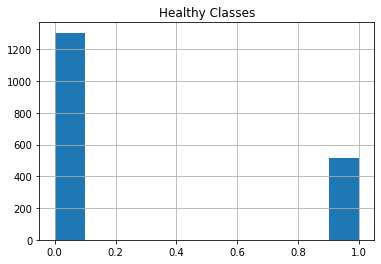

In [10]:
dataset.healthy.hist()
plt.title('Healthy Classes')

Text(0.5, 1.0, 'Multiple Diseases Classes')

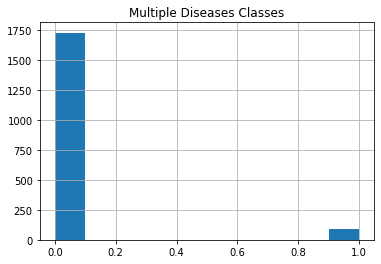

In [11]:
dataset.multiple_diseases.hist()
plt.title('Multiple Diseases Classes')

Text(0.5, 1.0, 'Rust Classes')

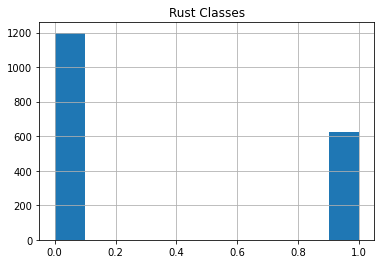

In [12]:
dataset.rust.hist()
plt.title('Rust Classes')

Text(0.5, 1.0, 'Scab Classes')

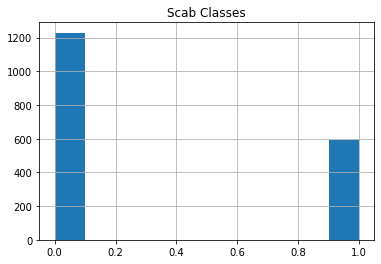

In [13]:
dataset.scab.hist()
plt.title('Scab Classes')

## Class Image Visualisation

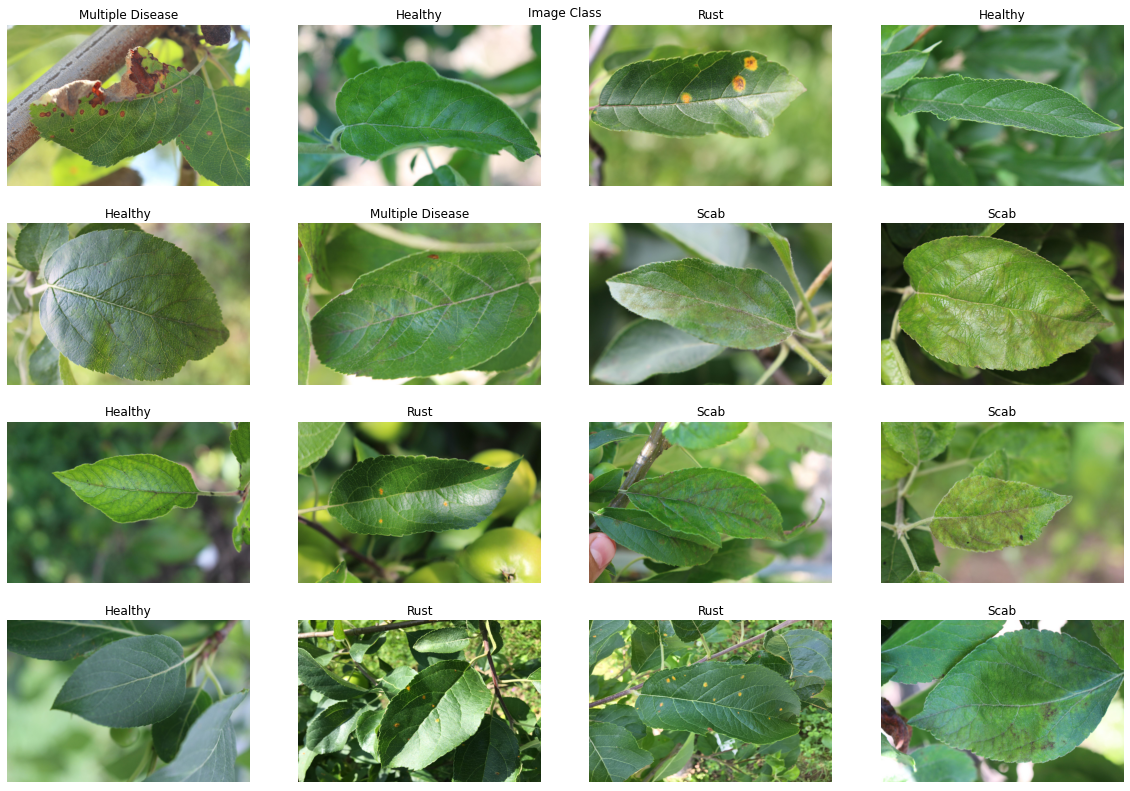

In [14]:
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 4
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1, columns*rows +1):
    img = plt.imread(f'/kaggle/input/plant-pathology-2020-fgvc7/images/Train_{i}.jpg')
    fig.add_subplot(rows, columns, i)
    
    if dataset.healthy[i] == 1:
        plt.title('Healthy')
    elif dataset.multiple_diseases[i] == 1:
        plt.title('Multiple Disease')
    elif dataset.rust[i] == 1:
        plt.title('Rust')
    else:
        plt.title('Scab')
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Image Segmentation

Multiple Histogram for different pixles intensity values

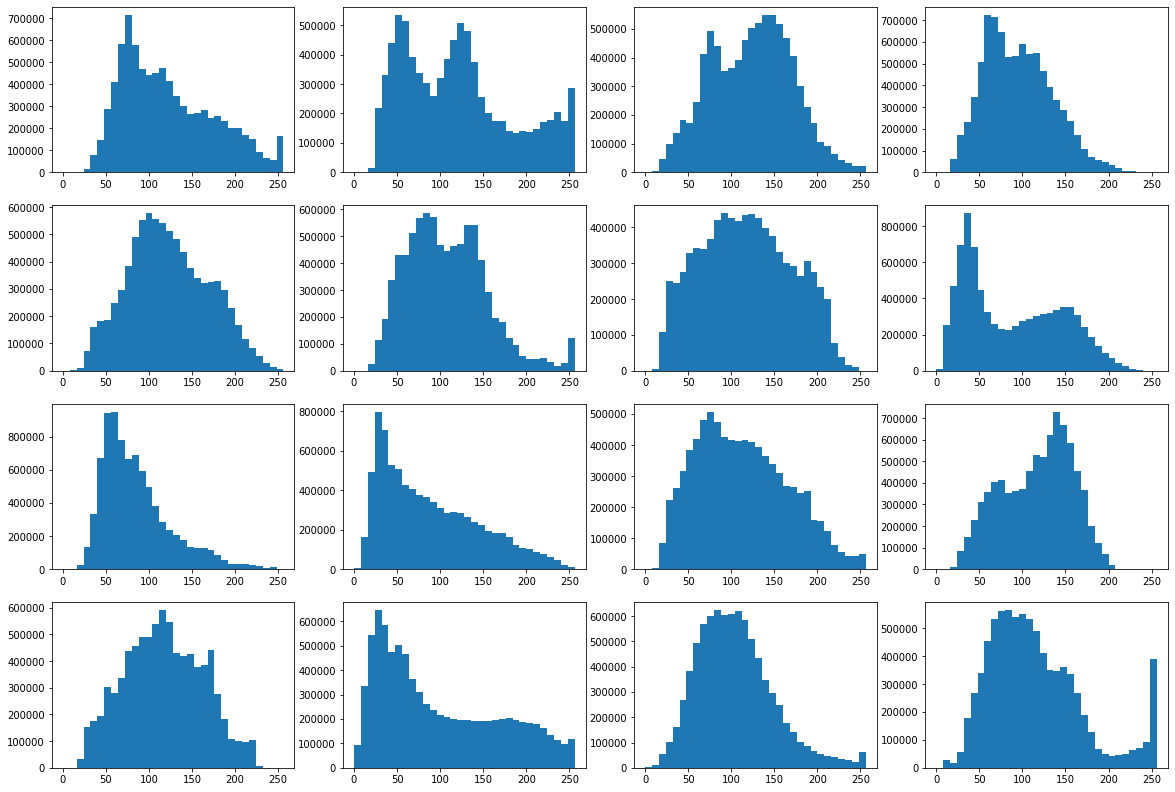

In [15]:
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 4
rows = 4
plt.axis('off')
for i in range(1, columns*rows +1):
    img = plt.imread(f'/kaggle/input/plant-pathology-2020-fgvc7/images/Train_{i}.jpg')
    fig.add_subplot(rows, columns, i)
    plt.hist(img.ravel(), bins=32, range=[0, 256])
plt.show()

In [16]:
img.shape

(1365, 2048, 3)

# Making Training Data

## Reading data from Keras Generators

In [17]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [18]:
X_train, X_valid = train_test_split(dataset, test_size=0.05, shuffle=False)

## Making a Tensorflow Dataset

In [19]:
BATCH_SIZE = 8

train_generator = datagen.flow_from_dataframe(dataset, 
                    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                    x_col='image_id',
                    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] , 
                    target_size=(512, 512), 
                    class_mode='raw',
                    batch_size=BATCH_SIZE, shuffle=False)

valid_generator = datagen.flow_from_dataframe(X_valid, 
                    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                    x_col='image_id',
                    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] , 
                    target_size=(512, 512), 
                    class_mode='raw',
                    batch_size=BATCH_SIZE, shuffle=False) 

Found 1821 validated image filenames.
Found 92 validated image filenames.


## Generator Images Visualisations

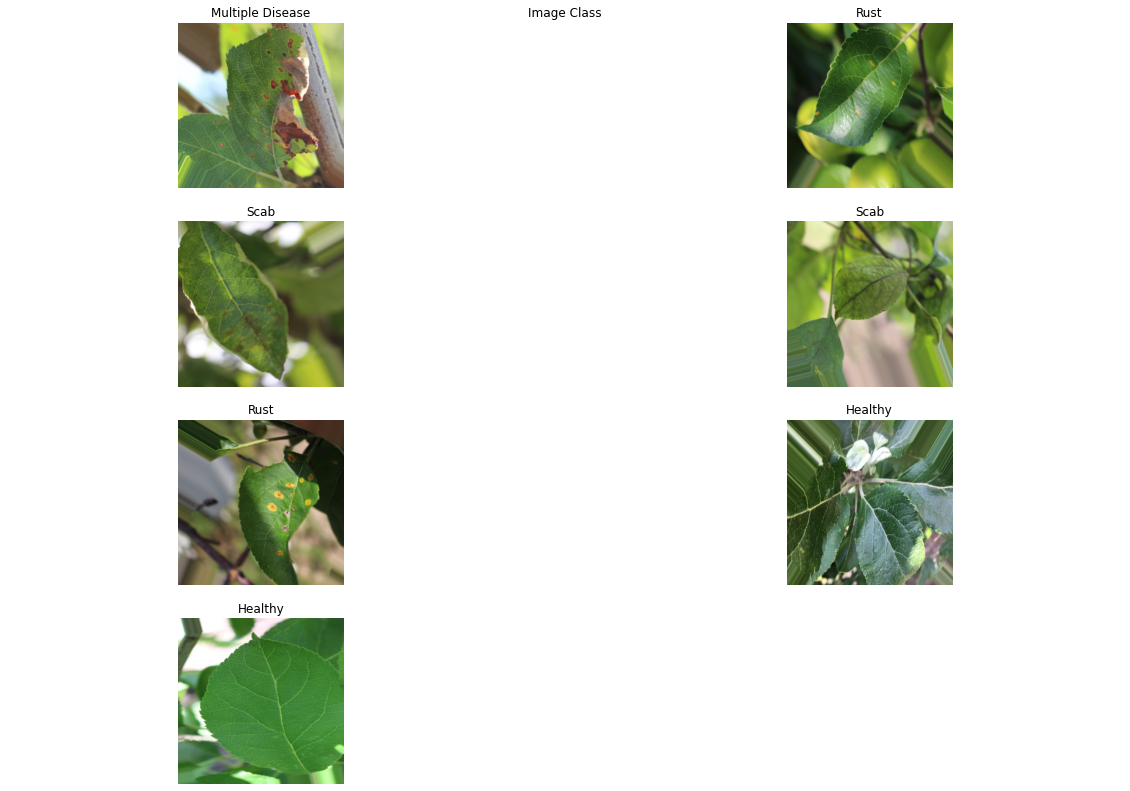

In [20]:
w=10
h=10
fig=plt.figure(figsize=(20, 14))
columns = 2
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1, columns*rows):
    
    img_batch, label_batch = train_generator.next()
    fig.add_subplot(rows, columns, i)
    
    if label_batch[i][0] == 1:
        plt.title('Healthy')
    elif label_batch[i][1] == 1:
        plt.title('Multiple Disease')
    elif label_batch[i][2] == 1:
        plt.title('Rust')
    else:
        plt.title('Scab')
        
    plt.imshow(img_batch[i])
    plt.axis('off')
plt.show()

# Making The Models

## Xception Model

In [21]:

xception_model = tf.keras.models.Sequential([
  tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(512, 512, 3)),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(4,activation='softmax')
])
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


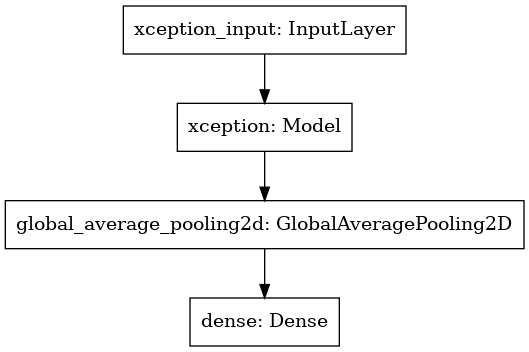

In [22]:
tf.keras.utils.plot_model(xception_model, to_file='xception_model.png')

## DenseNet121

In [23]:

densenet_model = tf.keras.models.Sequential([
    tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',input_shape=(512, 512, 3)),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(4,activation='softmax')
])
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


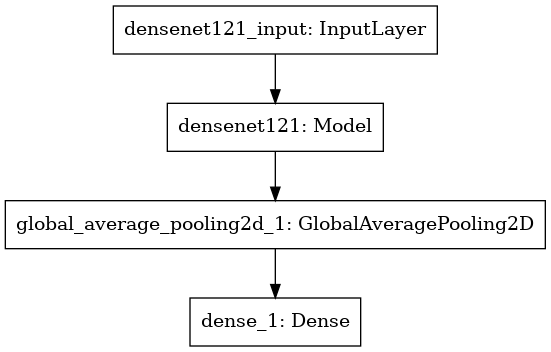

In [24]:
tf.keras.utils.plot_model(densenet_model, to_file='densenet_model.png')

# Ensembling the Models

In [25]:
inputs = tf.keras.Input(shape=(512, 512, 3))

xception_output = xception_model(inputs)
densenet_output = densenet_model(inputs)

outputs = tf.keras.layers.average([densenet_output, xception_output])


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            7041604     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4)            20869676    input_3[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 4)            0           sequential_1[1][0]               
                                                                 sequential[1][0]             

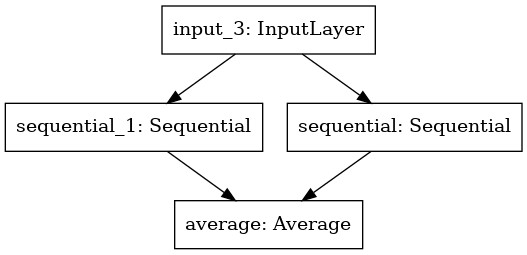

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png')

## Setting the hyperparameters & Callbacks

Learning rate schedule: 1e-05 to 0.0001 to 1e-05


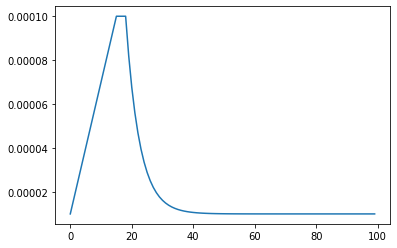

In [27]:
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=2, save_best_only=True)

# Tensordash is used for getting live model training status, like accuracy or loss, in your phone, sure to checkout here: https://github.com/CleanPegasus/TensorDash
histories = Tensordash(
    email = secret_value_0, 
    password = secret_value_1, 
    ModelName = "Plant Disease Model")

# Training the Model

In [29]:
# Model training 
model_history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[model_checkpoint,lr_callback, histories])

Train for 228 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
227/228 [============================>.] - ETA: 1s - loss: 1.0808 - accuracy: 0.5764
Epoch 00001: val_accuracy improved from -inf to 0.77174, saving model to model.h5
228/228 [==============================] - 278s 1s/step - loss: 1.0798 - accuracy: 0.5772 - val_loss: 0.7100 - val_accuracy: 0.7717

Epoch 00002: LearningRateScheduler reducing learning rate to 1.6000000000000003e-05.
Epoch 2/100
227/228 [============================>.] - ETA: 1s - loss: 0.4978 - accuracy: 0.8577
Epoch 00002: val_accuracy improved from 0.77174 to 0.93478, saving model to model.h5
228/228 [==============================] - 248s 1s/step - loss: 0.4960 - accuracy: 0.8583 - val_loss: 0.2123 - val_accuracy: 0.9348

Epoch 00003: LearningRateScheduler reducing learning rate to 2.2e-05.
Epoch 3/100
227/228 [============================>.] - ETA: 1s - loss: 0.3085 - accuracy: 0.9040
Epoch 000

### Saving History

In [30]:
# Saving model history
pd.DataFrame(model_history.history).to_csv('ModelHistory.csv')

### Model History Visualisation

Text(0.5, 1.0, 'accuracy Plot')

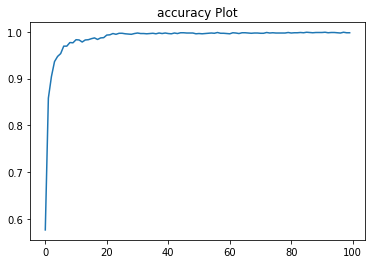

In [31]:
plt.plot(pd.DataFrame(model_history.history)['accuracy'])
plt.title("accuracy Plot")

Text(0.5, 1.0, 'Loss Plot')

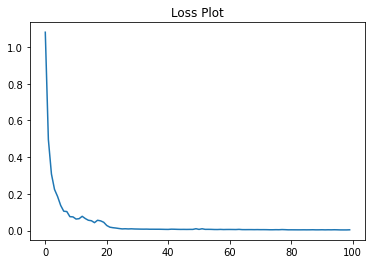

In [32]:
plt.plot(pd.DataFrame(model_history.history)['loss'])
plt.title("Loss Plot")

Text(0.5, 1.0, 'Validation Accuracy Plot')

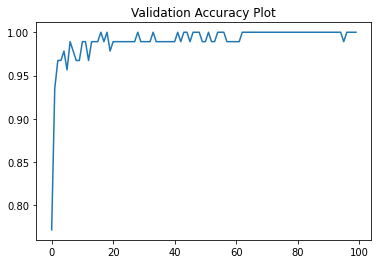

In [33]:
plt.plot(pd.DataFrame(model_history.history)['val_accuracy'])
plt.title("Validation Accuracy Plot")

Text(0.5, 1.0, 'Validation Accuracy Plot')

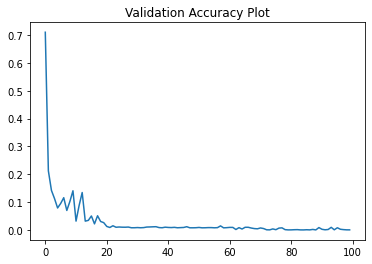

In [34]:
plt.plot(pd.DataFrame(model_history.history)['val_loss'])
plt.title("Validation Accuracy Plot")

# Predicting Classes

In [35]:
# Reading testing and submission data
test_dataset = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
submission = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
test_dataset

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [36]:
# Adding .jpg extension to image_id
test_dataset['image_id'] = test_dataset['image_id']+'.jpg'

In [37]:
test_gen = datagen.flow_from_dataframe(test_dataset, 
                    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                    x_col='image_id',
                    target_size=(512, 512), 
                    class_mode=None,
                    shuffle=False,
                    batch_size=8)

Found 1821 validated image filenames.


In [38]:
# Predicting class 
predictions = model.predict_generator(test_gen)

In [39]:
submission['healthy'] = predictions[:, 0]
submission['multiple_diseases'] = predictions[:, 1]
submission['rust'] = predictions[:, 2]
submission['scab'] = predictions[:, 3]

In [40]:
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.293066e-07,4.960460e-07,9.999994e-01,1.957720e-08
1,Test_1,2.531218e-06,2.072042e-06,9.999950e-01,3.478465e-07
2,Test_2,1.343778e-09,1.222801e-08,3.227613e-08,9.999999e-01
3,Test_3,9.999887e-01,6.636069e-07,8.456799e-06,2.162048e-06
4,Test_4,6.187040e-09,1.515457e-08,9.999974e-01,2.641845e-06
...,...,...,...,...,...
1816,Test_1816,1.256253e-09,6.237798e-06,9.999937e-01,3.099693e-09
1817,Test_1817,5.721491e-06,8.123470e-06,1.602107e-05,9.999701e-01
1818,Test_1818,6.402610e-08,1.077220e-07,9.999998e-01,8.000031e-09
1819,Test_1819,9.999983e-01,5.557402e-08,4.996133e-07,1.152112e-06


In [41]:
submission.to_csv('submission.csv', index=False)